# Simple model of the Nordic energy market

This model does not include the interaction and thus possible congestion between markets into account. 

#### Imports 

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Load the data

In [2]:
df = pd.read_csv("data/day_ahead_prices.csv")
df = df[df['country_code'] == "DK_1"]
df.rename(columns={'Unnamed: 0': 'Time', '0': 'Price'}, inplace=True)
df.head

<bound method NDFrame.head of                           Time   Price country_code
0    2022-06-01 00:00:00+02:00  220.00         DK_1
1    2022-06-01 01:00:00+02:00  207.45         DK_1
2    2022-06-01 02:00:00+02:00  199.09         DK_1
3    2022-06-01 03:00:00+02:00  182.53         DK_1
4    2022-06-01 04:00:00+02:00  182.28         DK_1
..                         ...     ...          ...
715  2022-06-30 19:00:00+02:00  479.00         DK_1
716  2022-06-30 20:00:00+02:00  450.00         DK_1
717  2022-06-30 21:00:00+02:00  394.21         DK_1
718  2022-06-30 22:00:00+02:00  355.17         DK_1
719  2022-06-30 23:00:00+02:00  258.08         DK_1

[720 rows x 3 columns]>

In [3]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 720
General statistics:


,Price
count,720.000000
mean,214.430250
std,85.421802
min,-0.010000
25%,163.862500
50%,202.630000
75%,263.580000
max,500.000000


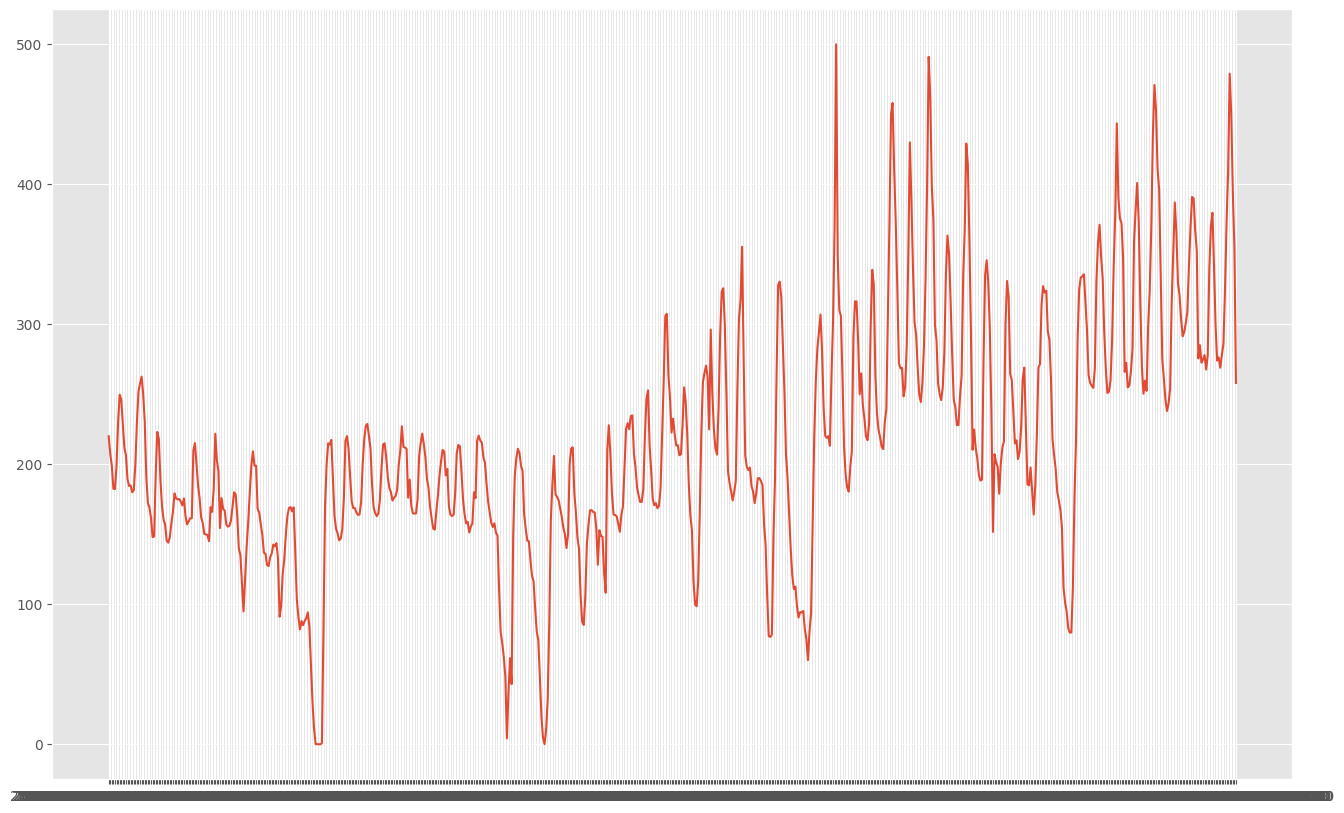

In [4]:
# Visualization
plt.plot(df['Time'], df['Price'])


In [19]:
# convert data to a matrix
y = df['Price'].values
N = len(y)
print("N=%d" % (N))

N=720


In [20]:
# Remove missing data
missing_perc = 0.4

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)]
ix_obs1 = perm1[int(missing_perc * N):]
y_mis1 = y[ix_mis1]
y_obs1 = y[ix_obs1]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
N = N_obs + N_mis
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 144
N_mis: 576


Define carry function for `jax.lax.scan`

In [21]:
def f(carry, noise_t):
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t 
    z_prev = z_t
    return (beta, z_prev, tau), z_t

Define the NumPyro model

In [22]:
def model(T, T_forecast, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=0., scale=1))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
    noises = numpyro.sample("noises", fn=dist.Normal(0, 1.), sample_shape=(T+T_forecast-1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=.1))

    # Propagate the dynamics using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    # Sample observed and missing values
    numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    return z_collection

In [24]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N, T_forecast=0, obs=y, ix_mis=ix_mis1, ix_obs=ix_obs1)


sample: 100%|██████████| 2000/2000 [00:05<00:00, 386.82it/s, 31 steps of size 1.98e-01. acc. prob=0.77] 


In [25]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta      0.10      0.56      0.11     -0.68      0.97     75.39      1.02
  noises[0]     -0.05      0.94     -0.12     -1.46      1.60    621.04      1.00
  noises[1]      0.04      0.95      0.06     -1.50      1.60    546.41      1.00
  noises[2]      0.15      1.06      0.12     -1.58      1.74    121.33      1.00
  noises[3]      0.02      0.97      0.02     -1.63      1.66    658.99      1.00
  noises[4]      0.13      1.09      0.18     -1.70      1.76    333.51      1.01
  noises[5]     -0.12      0.97     -0.13     -1.63      1.44    298.34      1.00
  noises[6]     -0.04      0.99     -0.05     -1.68      1.48    665.96      1.00
  noises[7]      0.02      1.01     -0.03     -1.61      1.68    411.61      1.00
  noises[8]     -0.09      1.11     -0.11     -1.72      1.78     81.91      1.03
  noises[9]     -0.07      0.95     -0.05     -1.64      1.43    946.44      1.00
 noises[10]    

In [26]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

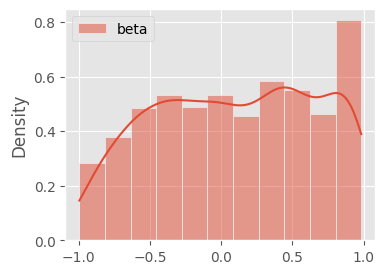

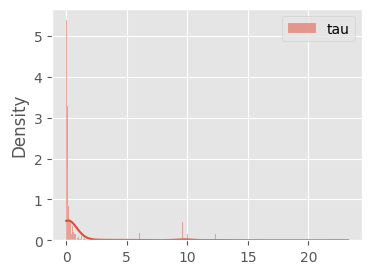

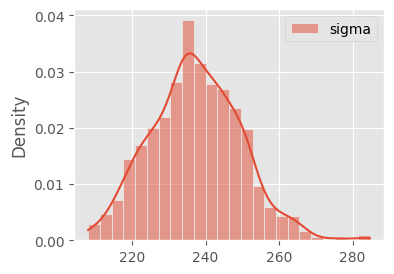

In [29]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()

In [30]:
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

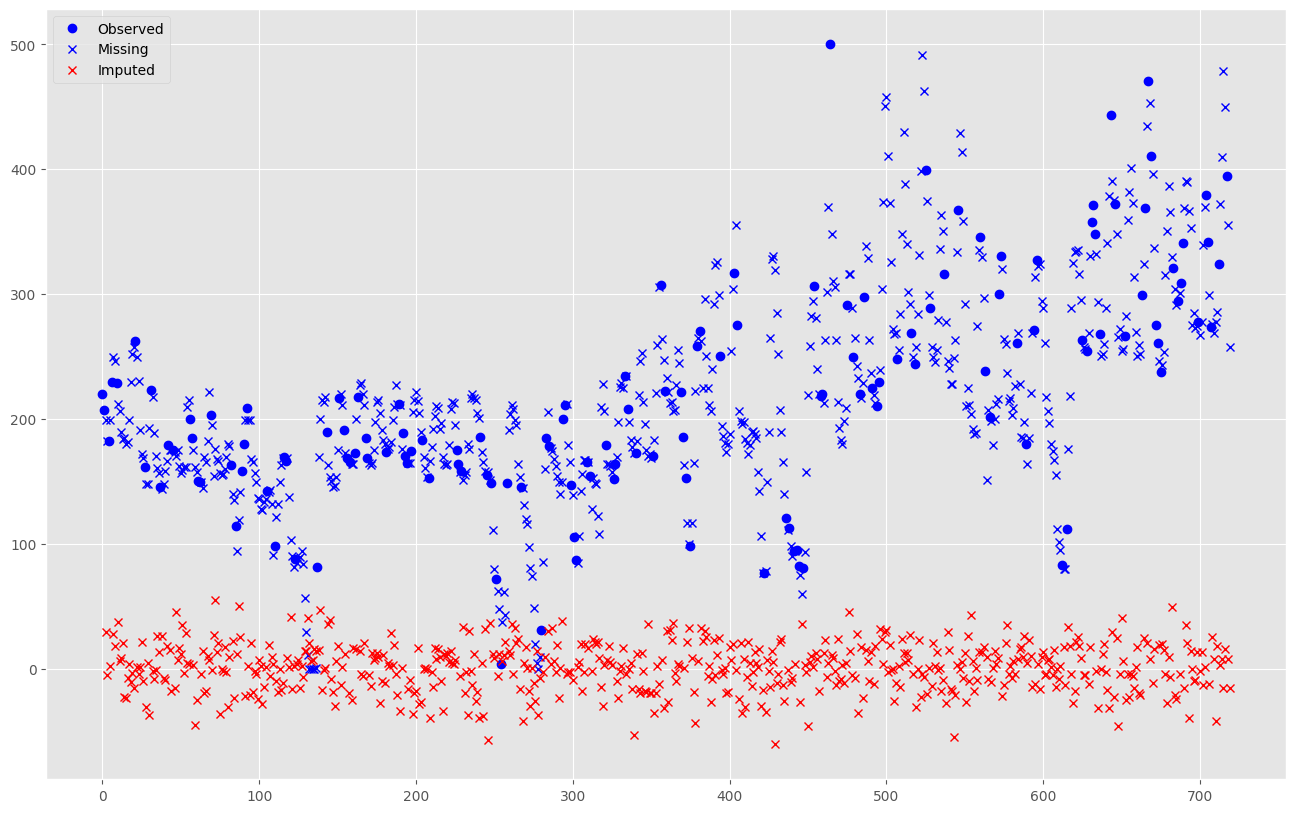

In [31]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
plt.legend(["Observed", "Missing", "Imputed"]);